In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] ="-1"

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, Bidirectional
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import re

Using TensorFlow backend.


In [2]:
def clean_text(text):
	
	# Remove punct.
	translator = str.maketrans('', '', string.punctuation)
	text = text.translate(translator)

	# to lower
	text = text.lower().split()

	# Remove stopwords
	stops = set(stopwords.words('english'))
	text = [w for w in text if not w in stops and len(w) >= 3]

	text = " ".join(text)
	### Cleaning
	text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text) # Numbers and symbols deleted
	
	# Shortened writings fixed.
	text = re.sub(r"what's", "what is ", text)
	text = re.sub(r"\'s", " ", text)
	text = re.sub(r"\'ve", " have ", text)
	text = re.sub(r"n't", " not ", text)
	text = re.sub(r"i'm", "i am ", text)
	text = re.sub(r"\'re", " are ", text)
	text = re.sub(r"\'d", " would ", text)
	text = re.sub(r"\'ll", " will ", text)

	### Stemming
	text = text.split()
	"""
	stemmer = SnowballStemmer('english')
	"""
	stemmer = WordNetLemmatizer()
	stemmed = [stemmer.lemmatize(word) for word in text]
	#stemmed = [stemmer.stem(word) for word in text]
	text = " ".join(stemmed)
	return text

In [3]:
path_emotion_file = "isear.csv"

# read csv
df_file = pd.read_csv(path_emotion_file, error_bad_lines=False,
                      warn_bad_lines=False, sep='|', encoding='latin1')

df = df_file[['Field1', 'SIT']]
old = (df.shape[0])
df = df[~df['SIT'].str.contains('\[')]
df = df.reset_index(drop=True)
print("%d sentences deleted."%(old-df.shape[0]))

df['SIT'] = df['SIT'].map(lambda x: clean_text(x))

classnum=sorted(set(df['Field1']))
macro_to_id = dict((note, number) for number, note in enumerate(classnum))

def fun(i):
    return macro_to_id[i]

df['Field1']=df['Field1'].apply(fun)

labels = []

for idx in df['Field1']:
    labels.append(idx)

198 sentences deleted.


In [4]:
vocabulary_size = 20000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(df['SIT'])
sequences = tokenizer.texts_to_sequences(df['SIT'])
data = pad_sequences(sequences, maxlen=100)

In [5]:
labels = to_categorical(np.asarray(labels))
print('Shape of Data Tensor:', data.shape) # num of examples x Features
print('Shape of Label Tensor:', labels.shape) # num of examples x Class

Shape of Data Tensor: (7305, 100)
Shape of Label Tensor: (7305, 7)


In [6]:
# Shuffling
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [7]:
nb_test_samples = int(0.2 * data.shape[0])

x_train = data[:-nb_test_samples]
y_train = labels[:-nb_test_samples]
x_test = data[-nb_test_samples:]
y_test = labels[-nb_test_samples:]

In [8]:
def getGlove(filename, vocabulary_size, vectorDim, tokenizer):
	embeddings_index = {}
	f = open(filename,encoding='utf8')
	for line in f:
	    values = line.split()
	    word = values[0]
	    coefs = np.asarray(values[1:], dtype='float32')
	    embeddings_index[word] = coefs
	f.close()
	print('Total %s word vectors in %s.' % (len(embeddings_index), filename))
	count = 0
	total = len(tokenizer.word_index.items())
	embedding_matrix = np.zeros((vocabulary_size+1, vectorDim))
	for word, index in tokenizer.word_index.items():
	    if index > vocabulary_size - 1:
	        break
	    else:
	        embedding_vector = embeddings_index.get(word)
	        if embedding_vector is not None:
	            embedding_matrix[index] = embedding_vector
	            count += 1

	return embedding_matrix, total, count

In [9]:
# Get Glove matrix
embedding_matrix, total, count = getGlove("glove.6B.100d.txt", vocabulary_size, 100, tokenizer)
print("Total: %d, Found: %d"%(total, count))

Total 400000 word vectors in glove.6B.100d.txt.
Total: 8069, Found: 7212


### Network 1:
	model.add(Dropout(0.2))
	model.add(Conv1D(64, 5, activation='relu'))
	model.add(MaxPooling1D(pool_size=4))
	model.add(LSTM(100))
	model.add(Dense(len(classnum), activation='softmax'))

### Network 2:
	model.add(Conv1D(128, 5, activation='relu'))					#1x96x128
	model.add(MaxPooling1D(3))                               		#1x32x128
	model.add(Conv1D(128, 5, activation='relu'))	                #1x28x128
	model.add(MaxPooling1D(28))		    # global max pooling        #1x1x128
	model.add(LSTM(128))
	model.add(Dense(128, activation='relu'))	                    #1x128
	model.add(Dense(len(classnum), activation='softmax'))			#1x7

### Network 3:
	model.add(Conv1D(128, 5, activation='relu'))					#1x96x128
	model.add(MaxPooling1D(3))                               		#1x32x128
	model.add(Conv1D(128, 5, activation='relu'))	                #1x28x128
	model.add(MaxPooling1D(28))		    # global max pooling        #1x1x128
	model.add(Flatten())	                                        #1x128
	model.add(Dense(128, activation='relu'))	                    #1x128
	model.add(Dense(len(classnum), activation='softmax'))	        #1x7

### Network 4:
	model.add(Bidirectional(LSTM(100)))
	model.add(Dense(len(classnum), activation='softmax'))

In [10]:
def neuralNet():
	model = Sequential()
	# Vectorizing sequence
	model.add(Embedding(vocabulary_size+1, 100, input_length=100, weights=[embedding_matrix], trainable=True))
	"""
	model.add(Dropout(0.2))
	model.add(Conv1D(64, 5, activation='relu'))
	model.add(MaxPooling1D(pool_size=4))
	model.add(LSTM(100))
	model.add(Dense(len(classnum), activation='softmax'))
	"""
	model.add(Bidirectional(LSTM(100)))
	model.add(Dense(len(classnum), activation='softmax'))
	
	# Compile model and print info screen.
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	print("Neural network")
	model.summary()
	return model

In [11]:
cb100d=ModelCheckpoint('model_2.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

model = neuralNet()

Neural network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          2000100   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 1407      
Total params: 2,162,307
Trainable params: 2,162,307
Non-trainable params: 0
_________________________________________________________________


In [12]:
def plotModel(model, filename):
	prestr = 'loss_test_'
	lossfile = prestr + filename
	lossfile = lossfile + '.png'

	fig1 = plt.figure()
	plt.plot(model.history['loss'],'r',linewidth=3.0)
	plt.plot(model.history['val_loss'],'b',linewidth=3.0)
	plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
	plt.xlabel('Epochs ',fontsize=16)
	plt.ylabel('Loss',fontsize=16)
	plt.title('Loss Curves :Network 6',fontsize=16)
	fig1.savefig(lossfile)

	prestr = 'accuracy_test_'
	accfile = prestr + filename
	accfile = accfile + '.png'
	fig2=plt.figure()
	plt.plot(model.history['acc'],'r',linewidth=3.0)
	plt.plot(model.history['val_acc'],'b',linewidth=3.0)
	plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
	plt.xlabel('Epochs ',fontsize=16)
	plt.ylabel('Accuracy',fontsize=16)
	plt.title('Accuracy Curves : Network 6',fontsize=16)
	fig2.savefig(accfile)

In [13]:
#history = model.fit(x_train, np.array(y_train), validation_split=0.2, epochs=10, callbacks=[cb100d])
#plotModel(history, "network6")
model.load_weights("model_100d.hdf5")

In [14]:
def toWord(tokenizer, sequence):
	index_word = {v: k for k, v in tokenizer.word_index.items()}
	words = []
	for seq in sequence:
		if seq != 0:
			words.append(index_word.get(seq))
	return " ".join(words)

In [15]:
def makePredictions(model, texts, labels, tokenizer):
	prediction = model.predict(texts)
	predicted = []
	right = [np.argmax(x) for x in labels]
	for pred in prediction:
		label = np.argmax(pred)
		predicted.append(label)

	accuracy = np.mean(np.array(right) == np.array(predicted))
	print("%d sentences tested." % len(texts))
	print("Accuracy: %.3f"% accuracy)
	return np.array(predicted), np.array(right)

predicted, correct = makePredictions(model, x_test, y_test, tokenizer)

1461 sentences tested.
Accuracy: 0.750


In [17]:
import itertools
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    """
    if normalize:
    	plt.savefig("normalized_confusion_network1.png")
    else:
    	plt.savefig("confusion_network1.png")
    """

Confusion matrix, without normalization
[[135  40   7  22   4   8  18]
 [  8 170   6   6   1  10  14]
 [  0   5 175   2   5  10   5]
 [ 11  14   9 137   3  13  18]
 [  2   3   4   1 168  13   8]
 [  5   9   3   2  14 158   5]
 [  5  15   4  20   7   6 153]]
Normalized confusion matrix
[[0.58 0.17 0.03 0.09 0.02 0.03 0.08]
 [0.04 0.79 0.03 0.03 0.   0.05 0.07]
 [0.   0.02 0.87 0.01 0.02 0.05 0.02]
 [0.05 0.07 0.04 0.67 0.01 0.06 0.09]
 [0.01 0.02 0.02 0.01 0.84 0.07 0.04]
 [0.03 0.05 0.02 0.01 0.07 0.81 0.03]
 [0.02 0.07 0.02 0.1  0.03 0.03 0.73]]


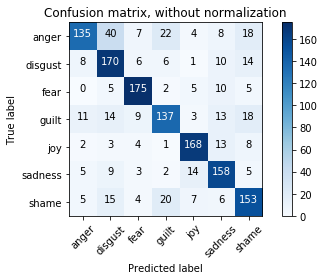

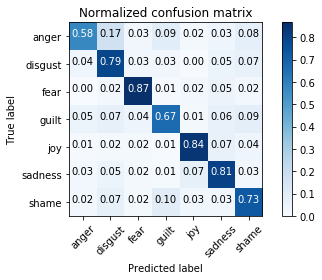

In [18]:
cnf_matrix = confusion_matrix(correct, predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plot_confusion_matrix(cnf_matrix, classes=classnum,
                      title='Confusion matrix, without normalization')

plot_confusion_matrix(cnf_matrix, classes=classnum, normalize=True,
                      title='Normalized confusion matrix')

#results = model.evaluate(x_test, y_test)
#print(results)

In [19]:
false_predicts_i = np.array(np.argwhere((predicted == correct) == False))

In [20]:
false_predicts = x_test[false_predicts_i]

In [22]:
for i in range(len(false_predicts_i)):
    print(i)
    l_pred = classnum[predicted[false_predicts_i[i]][0]]
    l_true = classnum[correct[false_predicts_i[i]][0]]
    sent = toWord(sequence=false_predicts[i][0], tokenizer=tokenizer)
    print("Predicted %s, Actual: %s"%(l_pred, l_true))
    print(sent)
    print()

0
Predicted disgust, Actual: anger
foreign student playing loud music biology examn

1
Predicted guilt, Actual: shame
said bad thing concerning friend

2
Predicted fear, Actual: guilt
native place riding cycle light night police man caught requested let would minute escaped

3
Predicted sadness, Actual: joy
discussion colleague mine realized conception man work similar mine

4
Predicted disgust, Actual: anger
heard someone telling lie best friend

5
Predicted anger, Actual: shame
insulted girlfriend peptalk

6
Predicted shame, Actual: disgust
sexual experience unknown woman sexual act could away without looking backwards

7
Predicted shame, Actual: anger
found someone knew well misunderstanding year

8
Predicted guilt, Actual: sadness
got argument someone abusive close friend later regretted

9
Predicted disgust, Actual: sadness
finding girl like like

10
Predicted disgust, Actual: anger
student kitchen share somebody drank juice pot one litre got one glass whole pot

11
Predicted ange

Predicted disgust, Actual: guilt
year ago mother found stealing relish pot fresh fish appetising

239
Predicted shame, Actual: sadness
failing examn

240
Predicted shame, Actual: disgust
curriculum year english course heavy prepared teacher asked several question class student ready answer question teacher frustated

241
Predicted shame, Actual: guilt
finishing homework time

242
Predicted sadness, Actual: guilt
close friend mine invited spend holiday kind good understanding however turned two cousin place however gave everything needed even transport money

243
Predicted guilt, Actual: anger
made appointment friend drink coffee togehter however third time week arrived hour late

244
Predicted guilt, Actual: shame
lunch restaurant friend paid bill change two dollar ten cent coin talking friend took two dollar coin forgot leave tip

245
Predicted sadness, Actual: joy
feel unbelievably happy relationship boyfriend reoccurring feeling

246
Predicted anger, Actual: guilt
girl one night cal